In [1]:
from rdkit import Chem
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
import itertools
import pandas as pd
from collections import Counter
import mols2grid

Set the default image size

In [2]:
uru.rd_set_image_size(300,300)

Create a demo molecule

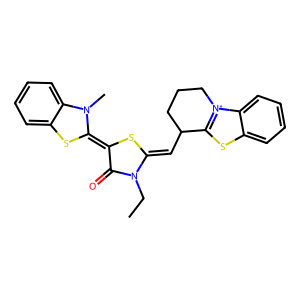

In [3]:
smi = "CCn1c(=O)/c(=C2\Sc3ccccc3N2C)s/c1=C\C1CCC[n+]2c1sc1ccccc12"
mol = Chem.MolFromSmiles(smi)
mol

Instantiate a RingSystemFinder object

In [4]:
ring_system_finder = uru.RingSystemFinder()

In order to demo the algorithm, we'll walk through it step by step.  First, we'll tag the bonds that shouldn't be cleaved when identifying ring systems.  Note that this is just to show how the RingSystemFinder works.  A simple way to find ring systems is shown below.

In [5]:
ring_system_finder.tag_bonds_to_preserve(mol)

Now look at a structure with those bonds highlighted.

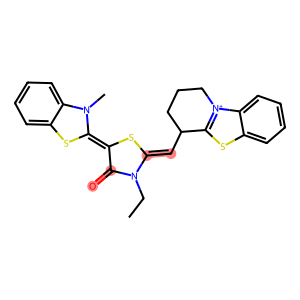

In [6]:
mol

Next, we cleave the tagged bonds.

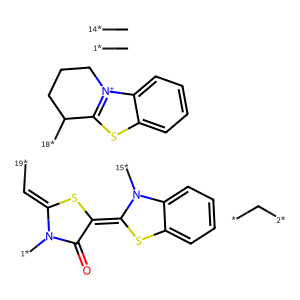

In [7]:
m1 = ring_system_finder.cleave_linker_bonds(mol)
m1

Now we can look at the ring systems.

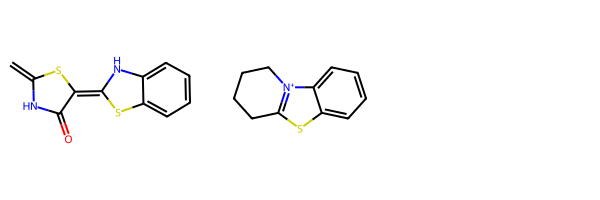

In [8]:
rx = ring_system_finder.cleanup_fragments(m1)
MolsToGridImage(rx)

That was just to show how the algorithm works.  Of course, this can also be done in one step.

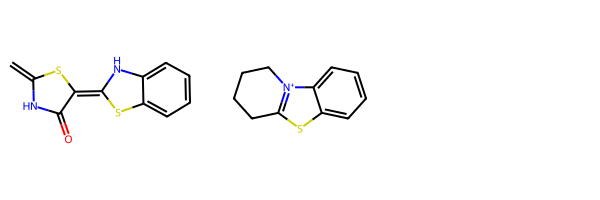

In [9]:
ring_system_list = ring_system_finder.find_ring_systems(mol, as_mols=True)
MolsToGridImage(ring_system_list)

View the ring systems with attached R-groups

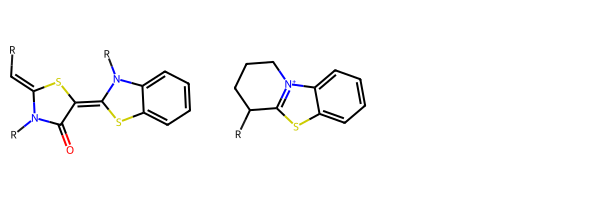

In [10]:
ring_system_list_with_Rgroups = ring_system_finder.find_ring_systems(mol, as_mols=True, keep_dummy=True)
MolsToGridImage(ring_system_list_with_Rgroups)

Let's look at a couple of applications of the RingSystemFinder.
Read a demo dataset

In [11]:
url = "https://raw.githubusercontent.com/PatWalters/useful_rdkit_utils/master/data/test.smi"
df = pd.read_csv(url,sep=" ",names=["SMILES","Name"])

View the dataframe

In [12]:
df

SMILES           Name
0                      Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1      CHEMBL700
1              CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O.[Na+]  CHEMBL1200982
2                                         Cl.N=C(N)N  CHEMBL1200728
3                             CC1=CC(=O)c2ccccc2C1=O      CHEMBL590
4  Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n...  CHEMBL1370561
5  C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[...     CHEMBL1395
6  C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@@]2(C)[C@H]1CC...     CHEMBL1536
7  Cc1cc(OP(=O)([O-])[O-])c2ccccc2c1OP(=O)([O-])[...  CHEMBL3989728
8                CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1      CHEMBL411
9                      Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1      CHEMBL439

Add an RDKit molecule to the dataframe

In [13]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

In [14]:
df.mol = df.mol.apply(uru.get_largest_fragment)

In [15]:
df.SMILES = df.mol.apply(Chem.MolToSmiles)

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [16]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)

In [17]:
df.ring_sytems.values

array([list(['c1ccccc1', 'c1ccncc1']), list(['O=C1CC(=O)NC(=O)[N-]1']),
       list([]), list(['O=C1C=CC(=O)c2ccccc21']),
       list(['O=c1[nH]c(=O)c2[nH]cnc2[nH]1']),
       list(['O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H]2CC1']),
       list(['C=C1CCCCC1=C', 'C=C1CCC[C@@H]2CCC[C@@H]12']),
       list(['c1ccc2ccccc2c1']), list(['c1ccccc1', 'c1ccccc1']),
       list(['c1ccccc1', 'c1cncnc1'])], dtype=object)

See how many times each ring system occurs

In [18]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"])
ring_count_df.sort_values("Count",ascending=False,inplace=True)

View the ring system frequencies

In [19]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [20]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [21]:
res

0            [(c1ccccc1, 2568039), (c1ccncc1, 275595)]
1                         [(O=C1CC(=O)NC(=O)[N-]1, 8)]
2                                                   []
3                      [(O=C1C=CC(=O)c2ccccc21, 4019)]
4               [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 6253)]
5    [(O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@...
6    [(C=C1CCCCC1=C, 587), (C=C1CCC[C@@H]2CCC[C@@H]...
7                            [(c1ccc2ccccc2c1, 55872)]
8           [(c1ccccc1, 2568039), (c1ccccc1, 2568039)]
9            [(c1ccccc1, 2568039), (c1cncnc1, 100599)]
Name: mol, dtype: object

In [22]:
df['ring_freq'] = [x[1] for x in res.apply(uru.get_min_ring_frequency)]

In [23]:
mols2grid.display(df.sort_values("ring_freq", ascending=False),mol_col="mol",subset=["img","ring_freq"])

MolGridWidget()

In [24]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)

In [25]:
df.ring_sytems.values

array([list(['c1ccccc1', 'c1ccncc1']), list(['O=C1CC(=O)NC(=O)[N-]1']),
       list([]), list(['O=C1C=CC(=O)c2ccccc21']),
       list(['O=c1[nH]c(=O)c2[nH]cnc2[nH]1']),
       list(['O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H]2CC1']),
       list(['C=C1CCCCC1=C', 'C=C1CCC[C@@H]2CCC[C@@H]12']),
       list(['c1ccc2ccccc2c1']), list(['c1ccccc1', 'c1ccccc1']),
       list(['c1ccccc1', 'c1cncnc1'])], dtype=object)

See how many times each ring system occurs

In [26]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"])
ring_count_df.sort_values("Count",ascending=False,inplace=True)

View the ring system frequencies

In [27]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [28]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [29]:
res

0            [(c1ccccc1, 2568039), (c1ccncc1, 275595)]
1                         [(O=C1CC(=O)NC(=O)[N-]1, 8)]
2                                                   []
3                      [(O=C1C=CC(=O)c2ccccc21, 4019)]
4               [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 6253)]
5    [(O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@...
6    [(C=C1CCCCC1=C, 587), (C=C1CCC[C@@H]2CCC[C@@H]...
7                            [(c1ccc2ccccc2c1, 55872)]
8           [(c1ccccc1, 2568039), (c1ccccc1, 2568039)]
9            [(c1ccccc1, 2568039), (c1cncnc1, 100599)]
Name: mol, dtype: object

In [30]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()

In [31]:
df

SMILES           Name  \
0                      Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1      CHEMBL700   
1                    CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O  CHEMBL1200982   
2                                            N=C(N)N  CHEMBL1200728   
3                             CC1=CC(=O)c2ccccc2C1=O      CHEMBL590   
4                         Cn1c(=O)c2[nH]cnc2n(C)c1=O  CHEMBL1370561   
5  C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[...     CHEMBL1395   
6  C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...     CHEMBL1536   
7  Cc1cc(OP(=O)([O-])[O-])c2ccccc2c1OP(=O)([O-])[O-]  CHEMBL3989728   
8                CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1      CHEMBL411   
9                      Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1      CHEMBL439   

                                             mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x3697b0d60>   
1  <rdkit.Chem.rdchem.Mol object at 0x3697b1380>   
2  <rdkit.Chem.rdchem.Mol object at 0x3697b1460>   
3  <rdkit.Chem.rdchem.Mol object at 0x3697b13f0>   
4  <rdkit.Chem.rdchem.Mol object at 0x3697b14d0>   
5  <rdkit.Chem.rdchem.Mol object at 0x3697b1540>   
6  <rdkit.Chem.rdchem.Mol object at 0x3697b15b0>   
7  <rdkit.Chem.rdchem.Mol object at 0x3697b1620>   
8  <rdkit.Chem.rdchem.Mol object at 0x3697b1690>   
9  <rdkit.Chem.rdchem.Mol object at 0x3697b1700>   

                                         ring_sytems  ring_freq  \
0                               [c1ccccc1, c1ccncc1]     275595   
1                            [O=C1CC(=O)NC(=O)[N-]1]          8   
2                                                 []         -1   
3                            [O=C1C=CC(=O)c2ccccc21]       4019   
4                     [O=c1[nH]c(=O)c2[nH]cnc2[nH]1]       6253   
5  [O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H...        570   
6          [C=C1CCCCC1=C, C=C1CCC[C@@H]2CCC[C@@H]12]        587   
7                                   [c1ccc2ccccc2c1]      55872   
8                               [c1ccccc1, c1ccccc1]    2568039   
9                               [c1ccccc1, c1cncnc1]     100599   

                                            min_ring min_freq  
0                                           c1ccncc1   275595  
1                              O=C1CC(=O)NC(=O)[N-]1        8  
2                                                          -1  
3                              O=C1C=CC(=O)c2ccccc21     4019  
4                       O=c1[nH]c(=O)c2[nH]cnc2[nH]1     6253  
5  O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H]...      570  
6                                       C=C1CCCCC1=C      587  
7                                     c1ccc2ccccc2c1    55872  
8                                           c1ccccc1  2568039  
9                                           c1cncnc1   100599

In [32]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

As of version 0.75, there an easier way to do this using the **pandas_similes_list** method of the **RingSystemFinder** class. Let's start by reading some data. 

In [36]:
url = "https://raw.githubusercontent.com/PatWalters/useful_rdkit_utils/master/data/test.smi"
df = pd.read_csv(url,sep=" ",names=["SMILES","Name"])

Instantiate a **RingSystemLookup** object and call the **pandas_smiles_list** method with the SMILES column from **df** as the argument.  This produces a new dataframe with **ring_systems, min_ring, and min_freq**. 

In [37]:
ring_system_lookup = uru.RingSystemLookup()
ring_df = ring_system_lookup.pandas_smiles_list(df.SMILES)
ring_df

  0%|          | 0/10 [00:00<?, ?it/s]

ring_systems  \
0          [(c1ccncc1, 275595), (c1ccccc1, 2568039)]   
1                       [(O=C1CC(=O)NC(=O)[N-]1, 8)]   
2                                                 []   
3                    [(O=C1C=CC(=O)c2ccccc21, 4019)]   
4  [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 6253), (O=c1[n...   
5  [(O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@...   
6  [(C=C1CCCCC1=C, 587), (C=C1CCC[C@@H]2CCC[C@@H]...   
7                          [(c1ccc2ccccc2c1, 55872)]   
8         [(c1ccccc1, 2568039), (c1ccccc1, 2568039)]   
9          [(c1cncnc1, 100599), (c1ccccc1, 2568039)]   

                                            min_ring  min_freq  
0                                           c1ccncc1    275595  
1                              O=C1CC(=O)NC(=O)[N-]1         8  
2                                                           -1  
3                              O=C1C=CC(=O)c2ccccc21      4019  
4                       O=c1[nH]c(=O)c2[nH]cnc2[nH]1      6253  
5  O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H]...       570  
6                                       C=C1CCCCC1=C       587  
7                                     c1ccc2ccccc2c1     55872  
8                                           c1ccccc1   2568039  
9                                           c1cncnc1    100599

We can use the Pandas **[concat](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)** method to put the two dataframes together. 

In [38]:
df = pd.concat([df,ring_df],axis=1)
df

SMILES           Name  \
0                      Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1      CHEMBL700   
1              CCC(C)C1(CC)C(=O)[N-]C(=O)NC1=O.[Na+]  CHEMBL1200982   
2                                         Cl.N=C(N)N  CHEMBL1200728   
3                             CC1=CC(=O)c2ccccc2C1=O      CHEMBL590   
4  Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n...  CHEMBL1370561   
5  C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[...     CHEMBL1395   
6  C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@@]2(C)[C@H]1CC...     CHEMBL1536   
7  Cc1cc(OP(=O)([O-])[O-])c2ccccc2c1OP(=O)([O-])[...  CHEMBL3989728   
8                CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1      CHEMBL411   
9                      Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1      CHEMBL439   

                                        ring_systems  \
0          [(c1ccncc1, 275595), (c1ccccc1, 2568039)]   
1                       [(O=C1CC(=O)NC(=O)[N-]1, 8)]   
2                                                 []   
3                    [(O=C1C=CC(=O)c2ccccc21, 4019)]   
4  [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 6253), (O=c1[n...   
5  [(O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@...   
6  [(C=C1CCCCC1=C, 587), (C=C1CCC[C@@H]2CCC[C@@H]...   
7                          [(c1ccc2ccccc2c1, 55872)]   
8         [(c1ccccc1, 2568039), (c1ccccc1, 2568039)]   
9          [(c1cncnc1, 100599), (c1ccccc1, 2568039)]   

                                            min_ring  min_freq  
0                                           c1ccncc1    275595  
1                              O=C1CC(=O)NC(=O)[N-]1         8  
2                                                           -1  
3                              O=C1C=CC(=O)c2ccccc21      4019  
4                       O=c1[nH]c(=O)c2[nH]cnc2[nH]1      6253  
5  O=C1C=C2CC[C@H]3[C@@H]4CCC[C@H]4CC[C@@H]3[C@H]...       570  
6                                       C=C1CCCCC1=C       587  
7                                     c1ccc2ccccc2c1     55872  
8                                           c1ccccc1   2568039  
9                                           c1cncnc1    100599